### Data Preparation

Set up import and constants.

Constants explaination:

`CORD_TR`: This is a fixed meter cropsponding to 0.0001 decimal degree of coordinates at E/W at 45N/S, where Toronto's latitude stands.

`LANE_WD`: This is a fixed meter of how wide a road. 

These two constants are used to calculate errors when mapping traffic flow to nodes.

`ALPHA`: Please refer to equation~3. $\alpha$ is parameter that control the threshold of deciding if a road (edge) is conjested or not.

In [1]:
import pandas as pd
import numpy as np
import folium
import osmnx
import networkx
import time
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from smart_mobility_utilities.common import cost, Node, probability,randomized_search
from smart_mobility_utilities.viz import draw_route, draw_map
from smart_mobility_utilities.children import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# A fixed degree precision of E/W at 45N/S with 0.0001 degree.
CORD_TR = 7.87

# A fixed lane wide
LANE_WD = 3.33

# Alpha parameter
ALPHA = 0.172

Load traffic flow data and graph data.

In [22]:
# Retrieve traffice flow data for preprocessing.
df_traffic_flow = pd.read_csv("traffic-flow-2020.csv")

# Retrieve node and edge data. 
# graph = osmnx.graph_from_address("Toronto", dist=3000, clean_periphery=True, simplify=True, network_type='drive_service')
graph = osmnx.graph_from_point([43.66415636619444, -79.43023950001896], dist = 1000, clean_periphery=True, simplify=True)
nodes, edges = osmnx.graph_to_gdfs(graph)

In [23]:
nodes.head()

,y,x,highway,street_count,geometry
osmid,,,,,
20380931,43.668458,-79.439018,traffic_signals,4,POINT (-79.43902 43.66846)
20964572,43.659869,-79.435330,traffic_signals,4,POINT (-79.43533 43.65987)
20964573,43.660507,-79.432404,traffic_signals,3,POINT (-79.43240 43.66051)
20964574,43.661166,-79.429396,traffic_signals,4,POINT (-79.42940 43.66117)
20964575,43.662511,-79.423249,traffic_signals,4,POINT (-79.42325 43.66251)


In [24]:
edges.head()

osmid lanes               name    highway  \
u        v          key                                                   
20380931 707292602  0     444662976     4    Dufferin Street  secondary   
         707292634  0     446327377     4    Dufferin Street  secondary   
         710723714  0     542393840     5      Dupont Street  secondary   
         710723725  0    1098222382     5      Dupont Street  secondary   
20964572 3028824592 0     220917050     2  Bloor Street West    primary   

                        maxspeed  oneway reversed  length  \
u        v          key                                     
20380931 707292602  0         40   False     True  16.559   
         707292634  0         40   False    False  15.825   
         710723714  0        NaN   False     True  13.852   
         710723725  0        NaN   False    False  12.475   
20964572 3028824592 0         40   False    False  13.137   

                                                                  geometry  \
u        v          key                                                      
20380931 707292602  0    LINESTRING (-79.43902 43.66846, -79.43908 43.6...   
         707292634  0    LINESTRING (-79.43902 43.66846, -79.43895 43.6...   
         710723714  0    LINESTRING (-79.43902 43.66846, -79.43919 43.6...   
         710723725  0    LINESTRING (-79.43902 43.66846, -79.43886 43.6...   
20964572 3028824592 0    LINESTRING (-79.43533 43.65987, -79.43517 43.6...   

                        service access tunnel width  
u        v          key                              
20380931 707292602  0       NaN    NaN    NaN   NaN  
         707292634  0       NaN    NaN    NaN   NaN  
         710723714  0       NaN    NaN    NaN   NaN  
         710723725  0       NaN    NaN    NaN   NaN  
20964572 3028824592 0       NaN    NaN    NaN   NaN

Redesign traffic flow data based on our objective functions.

In [25]:
df_traffic_flow['count_date'] = pd.to_datetime(df_traffic_flow['count_date'], format='%Y-%m-%d')
df_flow = df_traffic_flow.groupby(['location_id']).mean().reset_index()
# Pedestrian, bike, and scoter doesn't matter. 
g_flow = df_flow.drop(columns=['nx_peds', 'sx_peds', 'ex_peds', 'wx_peds', 
                              'nx_bike', 'sx_bike', 'ex_bike', 'wx_bike', 
                              'nx_other', 'sx_other', 'ex_other', 'wx_other'])
g_flow = g_flow.loc[g_flow['centreline_type'] == 2]

# Add traffic flow together
n_previous = 35
g_flow["total"] = g_flow.iloc[:,-n_previous:].sum(axis=1)

# Normalize for reference only, will not be applied to edges. Weight of edges will be calculated individually. 
g_flow['n-total'] = (g_flow['total'] - g_flow['total'].min())/(g_flow['total'].max() - g_flow['total'].min())

g_flow.head()

,location_id,_id,count_id,lng,lat,centreline_type,centreline_id,px,sb_cars_r,sb_cars_t,...,nb_bus_t,nb_bus_l,wb_bus_r,wb_bus_t,wb_bus_l,eb_bus_r,eb_bus_t,eb_bus_l,total,n-total
1,3925,59795.5,43407.0,-79.475274,43.636780,2.0,13468657.0,NaN,0.00000,122.25000,...,0.78125,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,308.96875,0.259248
2,3926,91443.5,45387.0,-79.485752,43.648312,2.0,13467247.0,334.0,4.21875,7.90625,...,0.00000,0.21875,0.03125,0.796875,0.34375,0.171875,1.03125,0.015625,572.71875,0.482588
3,3934,4976.5,39943.0,-79.534016,43.594361,2.0,13470639.0,240.0,8.43750,0.53125,...,0.00000,0.15625,0.00000,1.125000,0.06250,0.000000,1.18750,0.000000,327.06250,0.274570
4,3936,14835.5,40587.0,-79.483267,43.620511,2.0,13469793.0,1994.0,3.87500,0.00000,...,0.00000,0.00000,0.71875,0.718750,0.00000,0.000000,1.50000,0.000000,291.78125,0.244694
5,3939,24115.5,41169.0,-79.482878,43.688368,2.0,13460466.0,1422.0,30.93750,157.65625,...,1.62500,0.03125,0.37500,4.062500,0.28125,0.031250,3.93750,0.062500,676.53125,0.570495


Plot a map with locations have traffic flow information. From the map, it's clear that not every intersections have traffic flow data avaliable. We decide to pick destination and source from somehwere congested with traffic flow data. This will makes our research more informative.

In [ ]:
m = folium.Map(location=[43.662643, -79.395689], zoom_start=13)
for index, row in g_flow.iterrows():
    folium.Marker([row['lat'], row['lng']], popup=row['location_id'], icon = folium.Icon(color='red')).add_to(m)
m

In [26]:
edges['traffic_flow'] = 0.0

In [27]:
nodes_fixed = nodes.reset_index()

In [28]:
def find_traffic_flow(osmid, nodes, g_flow, lanes):
    lat = float(nodes.loc[nodes['osmid'] == osmid].y)
    lng = float(nodes.loc[nodes['osmid'] == osmid].x)
    
    tr = 0.0001*((LANE_WD * lanes)/CORD_TR)
    
    result = g_flow.loc[(g_flow['lat'] >= (lat-tr)) & (g_flow['lat'] <= (lat+tr)) & (g_flow['lng'] >= (lng-tr)) & (g_flow['lng'] <= (lng+tr))]
    
    # If there has no traffic flow on given edge, we pretend it has a reletively small traffic.
    if len(result) != 0:
        return float(result['total'])
    else:
        return float(g_flow['total'].quantile(0.25))
    

Calculate traffic flow on each edge.

In [29]:
for i, row in edges.iterrows():
    u = i[0]
    v = i[1]   
    
    try:
        lanes_num = int(row.lanes[0])
    except IndexError and TypeError as e:
        if pd.isnull(row.lanes):
            lanes_num = 1
        else:
            lanes_num = int(row.lanes)
    
    flow_u = find_traffic_flow(u, nodes_fixed, g_flow, lanes_num)
    flow_v = find_traffic_flow(v, nodes_fixed, g_flow, lanes_num)
    total_flow = flow_u + flow_v
    
    edges.loc[i, 'traffic_flow'] = total_flow
    
    

Normalize traffice flow. Refer to equation~5

In [30]:
edges['n_traffic_flow'] = (edges['traffic_flow'] - edges['traffic_flow'].min())/(edges['traffic_flow'].max() - edges['traffic_flow'].min())

To avoid 0 as divider.

In [31]:
edges.loc[edges['n_traffic_flow'] == 1, 'n_traffic_flow'] = 0.999

Update distance. Refer to equation~4

In [32]:
edges['updated_d'] = edges['length']/(1-edges['n_traffic_flow'])

Fill nan in maxspeed as 50 (A common speed limit on most roads)

In [33]:
edges[['maxspeed']] = edges[['maxspeed']].fillna(value=50)

Calculate our new weight. Refer to equation~3

In [34]:
edges['t'] = " "

for i, row in edges.iterrows():
    try:
        speed = float(row.maxspeed)
    except ValueError and TypeError as e:
        speed = float(row.maxspeed[0])
        
    if row.n_traffic_flow >= ALPHA:
        t = row.updated_d/speed
    else:
        t = row.length/speed
        
    edges.loc[i, 't'] = t
        

In [35]:
adjusted_edges = edges.copy()
adjusted_edges['length'] = adjusted_edges['t']
adjusted_edges.head(5)

osmid lanes               name    highway  \
u        v          key                                                   
20380931 707292602  0     444662976     4    Dufferin Street  secondary   
         707292634  0     446327377     4    Dufferin Street  secondary   
         710723714  0     542393840     5      Dupont Street  secondary   
         710723725  0    1098222382     5      Dupont Street  secondary   
20964572 3028824592 0     220917050     2  Bloor Street West    primary   

                        maxspeed  oneway reversed    length  \
u        v          key                                       
20380931 707292602  0         40   False     True   413.975   
         707292634  0         40   False    False   395.625   
         710723714  0         50   False     True    277.04   
         710723725  0         50   False    False     249.5   
20964572 3028824592 0         40   False    False  0.659563   

                                                                  geometry  \
u        v          key                                                      
20380931 707292602  0    LINESTRING (-79.43902 43.66846, -79.43908 43.6...   
         707292634  0    LINESTRING (-79.43902 43.66846, -79.43895 43.6...   
         710723714  0    LINESTRING (-79.43902 43.66846, -79.43919 43.6...   
         710723725  0    LINESTRING (-79.43902 43.66846, -79.43886 43.6...   
20964572 3028824592 0    LINESTRING (-79.43533 43.65987, -79.43517 43.6...   

                        service access tunnel width  traffic_flow  \
u        v          key                                             
20380931 707292602  0       NaN    NaN    NaN   NaN   1225.895833   
         707292634  0       NaN    NaN    NaN   NaN   1225.895833   
         710723714  0       NaN    NaN    NaN   NaN   1225.895833   
         710723725  0       NaN    NaN    NaN   NaN   1225.895833   
20964572 3028824592 0       NaN    NaN    NaN   NaN    618.643229   

                         n_traffic_flow     updated_d         t  
u        v          key                                          
20380931 707292602  0          0.999000  16559.000000   413.975  
         707292634  0          0.999000  15825.000000   395.625  
         710723714  0          0.999000  13852.000000    277.04  
         710723725  0          0.999000  12475.000000     249.5  
20964572 3028824592 0          0.502056     26.382506  0.659563

Edges updated, reassemble our graph.

In [36]:
adjusted_g = osmnx.graph_from_gdfs(nodes, adjusted_edges)

### Apply Dijkstra

Assume one collection center and one drop location.

In [67]:
collection = ['collection', 43.669142949308494, -79.4402416888576]

drop1 = ['drop1', 43.66415636619444, -79.43023950001896]
# drop2 = ['MEE-CHef', 43.663995240151735, -79.42493099894558]
drop2 = ['drop2', 43.66345802563402, -79.41868287972488]


In [68]:
source_point = (collection[1], collection[2])
destination_point1 = (drop2[1], drop2[2])

X_1 = [source_point[1], destination_point1[1]]
Y_1 = [source_point[0], destination_point1[0]]
closest_nodes_1 = osmnx.distance.nearest_nodes(adjusted_g,X_1,Y_1)

# Here, we use our weights 't' to calculate shortest path with dijkstra. length is already been replaced by t.
start_1 = time.time()
shortest_route_1 = networkx.shortest_path(G=adjusted_g,source=closest_nodes_1[0],target=closest_nodes_1[1], weight='length', method='dijkstra')
stop_1 = time.time()

In [69]:
m_dijkstra = folium.Map(location=[43.66469344988004, -79.43064784625537], zoom_start=15)

m_dijkstra = osmnx.plot_route_folium(G=adjusted_g,route=shortest_route_1, route_map=m_dijkstra)

folium.Marker([collection[1], collection[2]], icon = folium.Icon(color='red'), popup="Collection").add_to(m_dijkstra)
folium.Marker([drop2[1], drop2[2]], icon = folium.Icon(color='blue'), popup="drop2").add_to(m_dijkstra)

m_dijkstra

We can take this as a default reference. It's calculated with dijkstra from `osmnx`.

In [70]:
cost_dij = networkx.path_weight(adjusted_g, shortest_route_1, weight='length')

running_time_dij = (stop_1-start_1)
cost_dij, running_time_dij

(60.747533905811366, 0.011005401611328125)

### Apply SA

In [74]:
origin = Node(graph=graph, osmid=closest_nodes_1[0])
destination1 = Node(graph=graph, osmid=closest_nodes_1[1])

In [75]:
# A little utility function that finds the cost of a tour
# UPDATE: we will calculate weight based on our new feature t.
def cost_of_tour(G, tour):
    cost = 0
    for u,v in zip(tour, tour[1:]):
        cost += G[u][v]['length']
    cost += G[len(tour) - 1][0]['length']
    return cost

# A function to generate neighbours and select a route
def get_neighbours(G,tour):
    # generate 5 more paths to choose from
        neighbours = list()
        for _ in range(5):
            child = tour[:]
            i = random.randint(0, len(child) - 1)
            j = random.randint(0, len(child) - 1)
            child[i], child[j] = child[j], child[i]
            neighbours.append(child)
        
        return random.choice(neighbours)
    
def simulated_annealing(
    G, initial_solution, num_iter, schedule_function, neighbour_function, cost_function, use_tqdm=False
):
    
    current = initial_solution
    states = [cost_function(G,initial_solution)]
    if use_tqdm: pbar = tqdm(total=num_iter)
    for t in range(num_iter):
        # print("it {}..".format(t), end='\t')
        if use_tqdm: pbar.update()
        T = schedule_function(t)
        next_choice = neighbour_function(G,current)
        current_cost = cost_function(G, current)
        next_cost = cost_function(G, next_choice)
        delta_e = next_cost - current_cost
        if delta_e < 0 or probability(np.exp(-1 * delta_e / T)):
            current = next_choice
        states.append(cost_function(G, current))

    return current, cost_function(G,current), states

def get_neighbours_route(G, route):
    # Generate more paths to choose from
    neighbours = get_children(G,route,num_children=5)
    return random.choice(neighbours) 

def exp_schedule(k=20, lam=0.005, limit=100):
    function = lambda t: (k * np.exp(-lam*t) if t <limit else 0)
    return function

#### Experiment 1

In the first run, we apply SA with temperature of 200, number of iteration of 100.

In [ ]:
sa_result_best_solution_list = {}
sa_result_best_cost_list = {}
sa_result_best_state_list = {}
sa_result_time_list = {}

In [79]:
num_iterations = 100
schedule = exp_schedule(200, 0.05, 10000)
schedule

<function __main__.exp_schedule.<locals>.<lambda>(t)>

In [80]:
start_3 = time.time()
initial_solution = randomized_search(adjusted_g, origin.osmid, destination1.osmid)
print (f"Initial Solution: {initial_solution}")
print(f"Initial Cost: {cost(adjusted_g,initial_solution)}")
best_solution_1, best_cost_1, states_1 = simulated_annealing(
    adjusted_g,
    initial_solution,
    num_iterations,
    schedule,
    get_neighbours_route,
    cost,
    use_tqdm=True
)
stop_3 = time.time()

sa_result_best_solution_list.update({'ex1':best_solution_1})
sa_result_best_cost_list.update({'ex1':best_cost_1})
sa_result_best_state_list.update({'ex1':states_1})
sa_result_time_list.update({'ex1':stop_3-start_3})


Initial Solution: [5364620677, 5364620684, 707292602, 5364620670, 710723741, 3447614127, 707292525, 60954327, 60954337, 60954331, 10067682256, 10067682246, 10067682260, 3807667142, 51637133, 1332857221, 3807667143, 21631740, 3807667144, 60954338, 10067681853, 1655465745, 10034930286, 10034930296, 41332872, 10034930297, 10034930273, 1655464657, 415408786, 26007463, 579323134, 21631747, 579323172, 60797491, 25974439, 4347571660, 20964575, 4347571661, 25974440, 3052131163, 6960829075, 6960829073, 415408777, 439534295, 415408776, 439766408, 415408775, 20964576, 3052131179, 4085149957]
Initial Cost: 77.321


  0%|          | 0/100 [00:00<?, ?it/s]

#### Experiment 2

In the second run, we apply SA with temperature of 200, number of iteration of 500.

In [89]:
num_iterations = 500
start_4 = time.time()
initial_solution = randomized_search(adjusted_g, origin.osmid, destination1.osmid)
print (f"Initial Solution: {initial_solution}")
print(f"Initial Cost: {cost(adjusted_g,initial_solution)}")
best_solution_2, best_cost_2, states_2 = simulated_annealing(
    adjusted_g,
    initial_solution,
    num_iterations,
    schedule,
    get_neighbours_route,
    cost,
    use_tqdm=True
)
stop_4 = time.time()

sa_result_best_solution_list.update({'ex2':best_solution_2})
sa_result_best_cost_list.update({'ex2':best_cost_2})
sa_result_best_state_list.update({'ex2':states_2})
sa_result_time_list.update({'ex2':stop_4-start_4})

Initial Solution: [5364620677, 5364620684, 707292602, 5364620670, 710723741, 3447614127, 1950138867, 60954327, 60954337, 60954331, 10067682256, 1655465737, 10067682260, 1655465739, 51637133, 1332857221, 3807667143, 21631740, 3807667144, 60954338, 60955051, 21631739, 60797510, 60797509, 60797503, 60797531, 60797515, 60797557, 60797542, 60797552, 60797551, 60797540, 757462447, 7005289706, 757462453, 757462450, 7005289731, 439766412, 6455353471, 4085149959, 6455353460, 540603898, 439766410, 6617226332, 139373766, 415408775, 4085149956, 3052131179, 4085149957]
Initial Cost: 76.223


  0%|          | 0/500 [00:00<?, ?it/s]

#### Experiment 3

In the third run, we apply SA with temperature of 300, number of iteration of 500.

In [97]:
num_iterations = 500
schedule = exp_schedule(300, 0.05, 10000)
schedule

start_5 = time.time()
initial_solution = randomized_search(adjusted_g, origin.osmid, destination1.osmid)
print (f"Initial Solution: {initial_solution}")
print(f"Initial Cost: {cost(adjusted_g,initial_solution)}")
best_solution_3, best_cost_3, states_3 = simulated_annealing(
    adjusted_g,
    initial_solution,
    num_iterations,
    schedule,
    get_neighbours_route,
    cost,
    use_tqdm=True
)
stop_5 = time.time()

sa_result_best_solution_list.update({'ex3':best_solution_3})
sa_result_best_cost_list.update({'ex3':best_cost_3})
sa_result_best_state_list.update({'ex3':states_3})
sa_result_time_list.update({'ex3':stop_5-start_5})

Initial Solution: [5364620677, 5364620684, 707292602, 20380931, 710723725, 60954328, 67972587, 1332854931, 1950138867, 60954327, 60954337, 60954331, 10067682256, 10067682246, 10067682260, 1655465739, 10067681885, 3807667143, 10067681875, 1655465741, 10067507922, 1655465743, 10067681853, 1655465745, 10034930286, 1655464665, 1655464664, 60955050, 10034973615, 60954342, 6949013793, 67344562, 6960829065, 60797582, 67344539, 439535149, 415408785, 579323175, 10121715801, 415408784, 9025576639, 6960829070, 415408782, 20964575, 4347571661, 25974440, 3052131163, 25629253, 3052131164, 6363176175, 6363176164, 540603876, 20964576, 3052131179, 4085149957]
Initial Cost: 734.6792


  0%|          | 0/500 [00:00<?, ?it/s]

#### Experiment 4

In the forth run, we apply SA with temperature of 500, number of iteration of 500.

In [103]:
num_iterations = 500
schedule = exp_schedule(500, 0.05, 10000)
schedule

start_6 = time.time()
initial_solution = randomized_search(adjusted_g, origin.osmid, destination1.osmid)
print (f"Initial Solution: {initial_solution}")
print(f"Initial Cost: {cost(adjusted_g,initial_solution)}")
best_solution_4, best_cost_4, states_4 = simulated_annealing(
    adjusted_g,
    initial_solution,
    num_iterations,
    schedule,
    get_neighbours_route,
    cost,
    use_tqdm=True
)
stop_6 = time.time()

sa_result_best_solution_list.update({'ex4':best_solution_4})
sa_result_best_cost_list.update({'ex4':best_cost_4})
sa_result_best_state_list.update({'ex4':states_4})
sa_result_time_list.update({'ex4':stop_6-start_6})

Initial Solution: [5364620677, 5364620684, 707292602, 5364620670, 710723741, 3447614127, 707292525, 5364564412, 707292404, 5364564377, 5364564386, 5364564398, 1245045595, 5364564405, 707292329, 25629250, 707292282, 5364564399, 9025313537, 707292574, 9025313534, 9025313533, 707292434, 707292296, 7005255984, 757462462, 757462463, 7005289696, 757462451, 757462447, 7005289706, 757462453, 58405101, 58405094, 58405115, 58405743, 7005289722, 7005289730, 757462446, 4085149961, 1996544021, 3958745159, 7005289715, 332171233, 4085149956, 3052131179, 4085149957]
Initial Cost: 67.3143


  0%|          | 0/500 [00:00<?, ?it/s]

#### Visualize result

In [104]:
m_sa = folium.Map(location=[43.66469344988004, -79.43064784625537], zoom_start=15)

m_sa = osmnx.plot_route_folium(G=graph,route=best_solution_1, route_map=m_sa)
m_sa = osmnx.plot_route_folium(G=graph,route=best_solution_2, route_map=m_sa, color='red')
m_sa = osmnx.plot_route_folium(G=graph,route=best_solution_3, route_map=m_sa, color='green')

folium.Marker([collection[1], collection[2]], icon = folium.Icon(color='red'), popup="Collection").add_to(m_sa)
folium.Marker([drop2[1], drop2[2]], icon = folium.Icon(color='blue'), popup=drop2[0]).add_to(m_sa)

m_sa

In [99]:
cost_sa_1 = networkx.path_weight(adjusted_g, best_solution_1, weight='length')
running_time_sa_1 = (stop_3-start_3)
cost_sa_1, running_time_sa_1

(93.70357694763845, 411.43560791015625)

In [100]:
cost_sa_2 = networkx.path_weight(adjusted_g, best_solution_2, weight='length')
running_time_sa_2 = (stop_4-start_4)
cost_sa_2, running_time_sa_2

(91.67923033250155, 1078.0127460956573)

In [105]:
cost_sa_3 = networkx.path_weight(adjusted_g, best_solution_3, weight='length')

running_time_sa_3 = (stop_5-start_5)
cost_sa_3, running_time_sa_3

(82.69320164068934, 971.8817210197449)

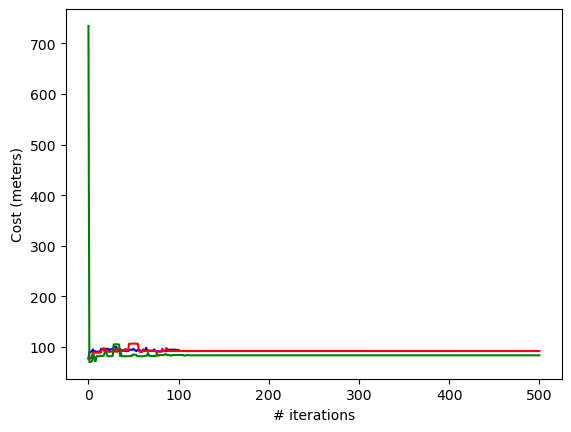

In [102]:
plt.xlabel("# iterations")
plt.ylabel("Cost (meters)")
plt.plot(states_1, color='blue')
plt.plot(states_2, color='red')
plt.plot(states_3, color='green')
plt.show()

### Apply GA

### Apply adaptive SA

In [106]:
def adaptive_simulated_annealing_probility_of_acceptance(
    G, initial_solution, num_iter, schedule_function, neighbour_function, cost_function, use_tqdm=False
):
    
    current = initial_solution
    states = [cost_function(G,initial_solution)]
    
    delta_e_list = []
    
    if use_tqdm: pbar = tqdm(total=num_iter)
    
    t = num_iter
    updated = False
    consecutive_non_updated = 0
    reheating = 2
    
    while t!=0:
        # print("it {}..".format(t), end='\t')
        if use_tqdm: 
            pbar.update()
        updated = False
        
        T = schedule_function(t)
        next_choice = neighbour_function(G,current)
        current_cost = cost_function(G, current)
        next_cost = cost_function(G, next_choice)
        delta_e = next_cost - current_cost
        
        delta_e_list.append(delta_e)
        max_e = max(delta_e_list)
        
        # Apply non-exponential probability
        if delta_e < 0 or probability((1-(delta_e/T))/max_e):
            current = next_choice
            updated = True
            consecutive_non_updated = 0
        else:
            consecutive_non_updated += 1
        
        # If it doesn't find any new minimum, we reheat it. But we only reheat twice.
        if not updated and reheating != 0 and consecutive_non_updated == 5:
            t += int(num_iter/10)
            reheating -= 1
            states.append(cost_function(G, current))
            consecutive_non_updated = 0
            continue
        
        states.append(cost_function(G, current))
        
        t -= 1

    return current, cost_function(G,current), states

#### Experiment 1

In the first run, we apply adaptive SA with temperature of 200, number of iteration of 100.

In [112]:
num_iterations = 100
schedule = exp_schedule(200, 0.05, 10000)
schedule

start_7 = time.time()
initial_solution = randomized_search(adjusted_g, origin.osmid, destination1.osmid)
print (f"Initial Solution: {initial_solution}")
print(f"Initial Cost: {cost(adjusted_g,initial_solution)}")
best_solution_5, best_cost_5, states_5 = adaptive_simulated_annealing_probility_of_acceptance(
    adjusted_g,
    initial_solution,
    num_iterations,
    schedule,
    get_neighbours_route,
    cost,
    use_tqdm=True
)
stop_7 = time.time()

Initial Solution: [5364620677, 5364620684, 707292602, 5364620670, 710723741, 3447614127, 1950138867, 60954327, 60954337, 707292549, 10067713408, 10067682251, 10067682256, 10067682246, 10067682260, 1655465739, 10067681885, 1655465742, 10067681881, 10067724242, 60955054, 60954338, 60955051, 21631739, 67344670, 60797506, 60797505, 60797565, 7917764906, 7917764911, 9322067823, 9322067822, 6571626151, 26002485, 60797558, 60797563, 26002488, 26002489, 757462450, 7005289731, 7005289722, 21292205, 4085149960, 4085149961, 1996544021, 3958745159, 7005289715, 332171233, 4085149956, 3052131179, 4085149957]
Initial Cost: 71.8558


  0%|          | 0/100 [00:00<?, ?it/s]

#### Experiment 2

In the second run, we apply adaptive SA with temperature of 200, number of iteration of 500.

In [115]:
num_iterations = 500
start_8 = time.time()
initial_solution = randomized_search(adjusted_g, origin.osmid, destination1.osmid)
print (f"Initial Solution: {initial_solution}")
print(f"Initial Cost: {cost(adjusted_g,initial_solution)}")
best_solution_6, best_cost_6, states_6 = simulated_annealing(
    adjusted_g,
    initial_solution,
    num_iterations,
    schedule,
    get_neighbours_route,
    cost,
    use_tqdm=True
)
stop_8 = time.time()

Initial Solution: [5364620677, 5364620684, 707292602, 5364620670, 710723741, 3447614127, 707292525, 5364564412, 707292404, 51637131, 707292499, 1332855483, 10067724217, 10067681885, 3807667143, 21631740, 3807667144, 10067507922, 1655465743, 1655464673, 1655464669, 6307634667, 4552451680, 10034930296, 41332872, 10034930297, 1332857245, 1655464660, 1957010070, 1655464659, 1655464658, 579323138, 415408785, 579323175, 10121715801, 415408784, 9025576639, 6960829070, 415408782, 6960829068, 4347571661, 25974440, 3052131163, 25629253, 3052131164, 6363176175, 6363176164, 540603876, 20964576, 415408880, 8095418799, 4085149957]
Initial Cost: 67.469


  0%|          | 0/500 [00:00<?, ?it/s]

#### Experiment 3

In the third run, we apply adaptive SA with temperature of 300, number of iteration of 500.

In [118]:
num_iterations = 500
schedule = exp_schedule(300, 0.05, 10000)
schedule

start_9 = time.time()
initial_solution = randomized_search(adjusted_g, origin.osmid, destination1.osmid)
print (f"Initial Solution: {initial_solution}")
print(f"Initial Cost: {cost(adjusted_g,initial_solution)}")
best_solution_7, best_cost_7, states_7 = simulated_annealing(
    adjusted_g,
    initial_solution,
    num_iterations,
    schedule,
    get_neighbours_route,
    cost,
    use_tqdm=True
)
stop_9 = time.time()

Initial Solution: [5364620677, 5364620684, 707292602, 5364620670, 710723741, 3447614127, 1950138867, 60954327, 60954337, 60954331, 10067682256, 1655465737, 10067682260, 1655465739, 10067681885, 1655465742, 10067681881, 3807667144, 60954338, 60955051, 1655465746, 10034973611, 10034973615, 60955050, 10034973608, 1655464662, 1655464660, 1957010070, 1655464659, 1655464658, 579323138, 579323134, 579323131, 415408871, 579323169, 415408873, 6960829069, 4347571660, 20964575, 4347571661, 25974440, 3052131163, 6960829075, 6960829073, 415408777, 439534295, 415408776, 439766408, 415408775, 20964576, 415408880, 8095418799, 4085149957]
Initial Cost: 71.5903


  0%|          | 0/500 [00:00<?, ?it/s]

In [119]:
m_asa = folium.Map(location=[43.66469344988004, -79.43064784625537], zoom_start=15)

m_asa = osmnx.plot_route_folium(G=graph,route=best_solution_7, route_map=m_asa, color='green')

folium.Marker([collection[1], collection[2]], icon = folium.Icon(color='red'), popup="Collection").add_to(m_asa)
folium.Marker([drop2[1], drop2[2]], icon = folium.Icon(color='blue'), popup=drop2[0]).add_to(m_asa)

m_asa

In [120]:
cost_sa_5 = networkx.path_weight(adjusted_g, best_solution_7, weight='length')

running_time_sa_5 = (stop_8-start_8)
cost_sa_5, running_time_sa_5

(85.46456596089078, 2287.019469022751)